# Viscosity Prediction: Hybrid EOS Tuning & Random Forest
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Oil & Gas PVT Analytics

## 1. Project Objective
We aim to predict the **Viscosity** of a black oil sample.
Instead of relying purely on black-box machine learning, we will use a **Hybrid Physics-AI approach**:
1.  **Physics Layer:** Tune the *Peng-Robinson Equation of State (EOS)* parameters ($P_c, T_c, \omega$) using **Genetic Algorithms (DEAP)** to match experimental density.
2.  **ML Layer:** Use the physically-consistent Density from the tuned EOS as a feature to train a **Random Forest Regressor** for viscosity.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configuration to suppress repeated warnings during GA runtime
import warnings
warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv('pvt_data_synthetic.csv')

print(f"Data Loaded: {df.shape[0]} rows")
df.head()

Data Loaded: 500 rows


,Pressure_psia,Temperature_F,Exp_Density_kgm3,Exp_Viscosity_cp
0,2498.160475,204.724257,301.598810,0.323741
1,4802.857226,180.414455,364.087610,0.528631
2,3927.975767,146.429142,403.226352,0.782019
3,3394.633937,222.069253,305.667196,0.344441
4,1624.074562,202.709676,294.069072,0.280754


## 2. The Physics Engine: Peng-Robinson EOS
To tune the EOS, we first need a Python function that replicates the physics.
The **Peng-Robinson EOS** relates Pressure ($P$), Temperature ($T$), and Molar Volume ($V_m$) using critical properties.

$$P = \frac{RT}{V_m - b} - \frac{a \alpha}{V_m^2 + 2bV_m - b^2}$$

We will solve the **Cubic Equation for Z-factor** to find the fluid density.

In [4]:
R_gas = 10.7316 # psi ft3 / (lb-mol R)

def calculate_pr_density(P, T_F, Pc, Tc_F, omega):
    """
    Calculates density (kg/m3) using Peng-Robinson EOS logic.
    """
    # 1. Convert Units
    T = T_F + 459.67  # Fahrenheit to Rankine
    Tc = Tc_F + 459.67
    Tr = T / Tc       # Reduced Temperature
    
    # 2. Calculate EOS Parameters (a, b, alpha)
    # Kappa is the characteristic parameter for PR EOS
    kappa = 0.37464 + 1.54226*omega - 0.26992*(omega**2)
    alpha = (1 + kappa * (1 - np.sqrt(Tr)))**2
    
    a = 0.45724 * (R_gas**2 * Tc**2) / Pc * alpha
    b = 0.07780 * (R_gas * Tc) / Pc
    
    # 3. Coefficients for Cubic Z-factor Equation: Z^3 + c2*Z^2 + c1*Z + c0 = 0
    A = (a * P) / (R_gas**2 * T**2)
    B = (b * P) / (R_gas * T)
    
    c3 = 1.0
    c2 = -(1 - B)
    c1 = (A - 3*B**2 - 2*B)
    c0 = -(A*B - B**2 - B**3)
    
    # 4. Solve for Roots
    roots = np.roots([c3, c2, c1, c0])
    
    # Filter for real, positive roots
    real_roots = roots[np.isreal(roots)].real
    real_roots = real_roots[real_roots > 0]
    
    if len(real_roots) == 0:
        return np.nan # Algorithm failure case
        
    # Select Liquid Root (smallest Z implies highest density, usually liquid)
    Z_liquid = np.min(real_roots)
    
    # 5. Calculate Density
    Vm = Z_liquid * R_gas * T / P # Molar Volume
    MW = 150 # Assumed Molecular Weight for this synthetic oil
    rho_lb_ft3 = MW / Vm
    
    # Convert to kg/m3
    rho_kg_m3 = rho_lb_ft3 * 16.0185
    
    return rho_kg_m3

## 3. Genetic Algorithm (GA) for Parameter Tuning
We use the **DEAP** library to evolve parameters ($P_c, T_c, \omega$).
* **Genome:** `[Pc, Tc, Omega]`
* **Fitness Function:** Minimize RMSE between `Calculated Density` and `Experimental Density`.

In [5]:
# 1. Setup DEAP Environment
# Check if classes exist to avoid re-creation errors in Jupyter
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 2. Define Parameter Search Space (Genes)
toolbox.register("attr_pc", np.random.uniform, 300, 1000)  # Pc: 300-1000 psia
toolbox.register("attr_tc", np.random.uniform, 500, 1500)  # Tc: 500-1500 F
toolbox.register("attr_om", np.random.uniform, 0.01, 1.0)  # Omega: 0.01-1.0

# Define Individual and Population structure
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_pc, toolbox.attr_tc, toolbox.attr_om), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 3. Define Evaluation Function (The "Cost" Function)
def evaluate_eos(individual):
    Pc_curr, Tc_curr, Om_curr = individual
    
    # Constraint: Physical bounds sanity check
    if Pc_curr <= 0 or Tc_curr <= 0:
        return (1e6,) 
    
    # Efficiency: Calculate error on a random subset of data (Stochastic)
    subset = df.sample(n=50, random_state=42)
    
    calc_densities = []
    exp_densities = subset['Exp_Density_kgm3'].values
    
    for _, row in subset.iterrows():
        rho = calculate_pr_density(row['Pressure_psia'], row['Temperature_F'], 
                                   Pc_curr, Tc_curr, Om_curr)
        # Handle convergence failures
        if np.isnan(rho):
            rho = 1e6 # Heavy penalty
        calc_densities.append(rho)
            
    rmse = np.sqrt(mean_squared_error(exp_densities, calc_densities))
    return (rmse,)

# 4. Register Genetic Operators
toolbox.register("evaluate", evaluate_eos)
toolbox.register("mate", tools.cxBlend, alpha=0.5)        # Mate: Blend two individuals
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2) # Mutate: Add noise
toolbox.register("select", tools.selTournament, tournsize=3) # Select: Tournament

# 5. Run the GA Optimization
def main_ga():
    print("Starting Genetic Algorithm...")
    pop = toolbox.population(n=50) # Population size
    hof = tools.HallOfFame(1)      # Store best individual
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    
    # Run for 15 generations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    return hof[0]

best_params = main_ga()
tuned_Pc, tuned_Tc, tuned_Om = best_params

print(f"\n--- Best Parameters Found ---")
print(f"Pc: {tuned_Pc:.2f} psia")
print(f"Tc: {tuned_Tc:.2f} F")
print(f"Omega: {tuned_Om:.4f}")

Starting Genetic Algorithm...
gen	nevals	min   
0  	50    	135.17
1  	30    	99.0925
2  	31    	54.8101
3  	24    	64.7   
4  	27    	58.4374
5  	31    	54.7907
6  	33    	54.7907
7  	30    	54.9697
8  	25    	54.6097
9  	29    	52.324 
10 	27    	52.324 
11 	21    	52.324 
12 	26    	52.324 
13 	31    	50.0318
14 	36    	51.0968
15 	29    	51.2793

--- Best Parameters Found ---
Pc: 282.18 psia
Tc: 1667.36 F
Omega: -2.1557


## 4. Feature Engineering: Physics-Informed Features
Now that we have a tuned EOS, we calculate the **Tuned Density** for the entire dataset. This serves as a high-quality input feature for our ML model.

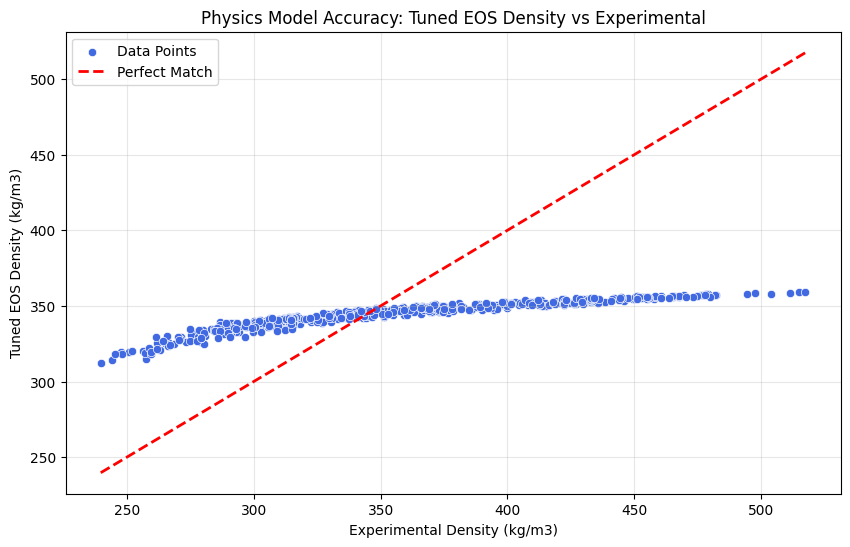

In [6]:
# Apply the best parameters to the full dataset
df['Tuned_EOS_Density'] = df.apply(
    lambda row: calculate_pr_density(row['Pressure_psia'], row['Temperature_F'],
                                     tuned_Pc, tuned_Tc, tuned_Om), axis=1
)

# Visualize the Tuning Quality
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Exp_Density_kgm3', y='Tuned_EOS_Density', data=df, color='royalblue', label='Data Points')
plt.plot([df['Exp_Density_kgm3'].min(), df['Exp_Density_kgm3'].max()], 
         [df['Exp_Density_kgm3'].min(), df['Exp_Density_kgm3'].max()], 'r--', linewidth=2, label='Perfect Match')
plt.title('Physics Model Accuracy: Tuned EOS Density vs Experimental')
plt.xlabel('Experimental Density (kg/m3)')
plt.ylabel('Tuned EOS Density (kg/m3)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Machine Learning: Viscosity Prediction
We now build a **Random Forest Regressor**.
* **Inputs:** Pressure, Temperature, AND Tuned_EOS_Density.
* **Target:** Viscosity.

--- Model Performance ---
RMSE: 0.0623 cp
R2 Score: 0.9277


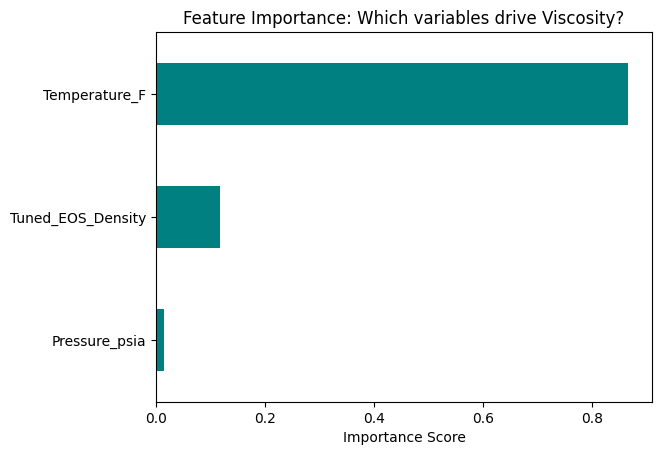

In [7]:
# Define Features and Target
X = df[['Pressure_psia', 'Temperature_F', 'Tuned_EOS_Density']]
y = df['Exp_Viscosity_cp']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Model Performance ---")
print(f"RMSE: {np.sqrt(mse):.4f} cp")
print(f"R2 Score: {r2:.4f}")

# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance: Which variables drive Viscosity?')
plt.xlabel('Importance Score')
plt.show()

## 6. Model Result Visualization

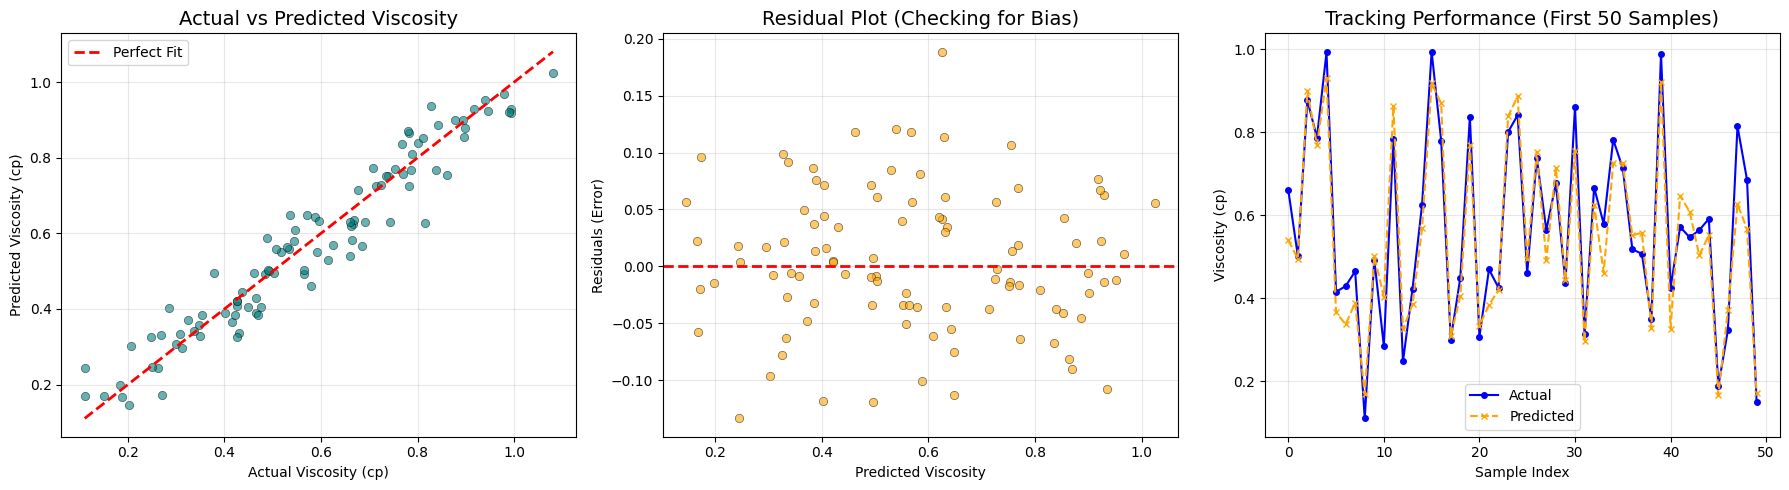

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_model_performance(y_test, y_pred):
    """
    Generates a 3-panel dashboard to visualize regression performance.
    """
    plt.figure(figsize=(18, 5))

    # --- Plot 1: Predicted vs Actual (Scatter) ---
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal', edgecolor='k')
    
    # 45-degree line (Perfect Prediction)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
    
    plt.title('Actual vs Predicted Viscosity', fontsize=14)
    plt.xlabel('Actual Viscosity (cp)')
    plt.ylabel('Predicted Viscosity (cp)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Plot 2: Residual Plot (Error Distribution) ---
    # Residuals = Actual - Predicted
    residuals = y_test - y_pred
    
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.title('Residual Plot (Checking for Bias)', fontsize=14)
    plt.xlabel('Predicted Viscosity')
    plt.ylabel('Residuals (Error)')
    plt.grid(True, alpha=0.3)

    # --- Plot 3: Line Plot (First 50 Samples) ---
    # Good for visual validation of tracking
    plt.subplot(1, 3, 3)
    limit = 50 
    x_ax = range(len(y_test[:limit]))
    plt.plot(x_ax, y_test[:limit], label="Actual", color='blue', marker='o', markersize=4)
    plt.plot(x_ax, y_pred[:limit], label="Predicted", color='orange', linestyle='--', marker='x', markersize=4)
    plt.title(f'Tracking Performance (First {limit} Samples)', fontsize=14)
    plt.xlabel('Sample Index')
    plt.ylabel('Viscosity (cp)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the function
plot_model_performance(y_test, y_pred)